In [ ]:
# Mount Drive to Access Data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Authenticate to access cloud bucket
from google.colab import auth
auth.authenticate_user()

# create a LOCAL directory in /content/  so you can move stuff from bucket to local
!mkdir /content/w281FinalProjectLogo
# copy from google bucket to local directory
!gsutil -m -q cp -r gs://w281finalprojectlogo/Logos-32plus_v1.0.1/preprocessedv2 /content/w281FinalProjectLogo/

### Import Libraries and Set Paths

In [ ]:
# Define directories
base_dir = '/content/drive/MyDrive/w281FinalProjectLogo/'
bucket = '/content/w281FinalProjectLogo/Logos-32plus_v1.0.1/'
john_dir = base_dir + '/john/'
fe_dir = base_dir + '/john/feature_extraction/'
model_dir = base_dir + '/john/manual_model/'
drive_save_dir = base_dir + 'Logos-32plus_v1.0.1/feature_extraction/'

# reading, writing to bucket
preproc_dir = bucket + 'preprocessedv2/'
bucket_save_dir = bucket + 'feature_extraction/'
da_path = preproc_dir + 'da/'
bb_path = preproc_dir + 'bb/'
cn_path = preproc_dir + 'cn/'

In [ ]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, \
      roc_auc_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA
import seaborn as sns

sys.path.append(model_dir)
from eval_fns import roc_ovr_all, visualize_errors

### Load Data, Split

In [ ]:
# Load df with extracted features
df = pd.read_pickle(drive_save_dir + 'fe_merged_all_112722.csv')
df.dropna(subset=['norm_hist'], inplace=True)
print(f"Num Bboxes: {len(df)}")
print(df['split'].value_counts())

Num Bboxes: 11446
train    10653
test       433
val        360
Name: split, dtype: int64


In [ ]:
# Prepare class map
df.sort_values('class_code', ascending=True, inplace=True)
class_df = df[['class_code', 'class']].drop_duplicates()
class_map = dict(class_df[['class_code', 'class']].values)
class_names = class_df['class'].unique()

In [ ]:
## Select features to use in modeling
# Section 1: Non-SIFT features
ns_features = ['cm_hsv_mean', 'cm_hsv_var', 'cm_hsv_skew',
                'cm_rgb_mean', 'cm_rgb_var', 'cm_rgb_skew',
                'cm_ycrcb_mean','cm_ycrcb_var', 'cm_ycrcb_skew',
                'hu_moments', 'contrast', 'dissimilarity',
                'homogeneity', 'energy', 'correlation', 'ASM']
                
# Non-SIFT: Combine each feature vector into 1-D array
features_ns = []
for idx, row in df.iterrows():
  vals = []
  for col in ns_features:
    vals.extend(list(row[col]))
  features_ns.append(vals)
df['features_ns'] = features_ns


# Section 2: All Features
all_features = ns_features + ['norm_hist']
                
# Combine each feature vector into 1-D array
features_all = []
for idx, row in df.iterrows():
  vals = []
  for col in all_features:
    vals.extend(list(row[col]))
  features_all.append(vals)
df['features_all'] = features_all

In [ ]:
## split df
train_df = df.loc[df['split']=='train', ].copy()
val_df = df.loc[df['split']=='val', ].copy()
test_df = df.loc[df['split']=='test', ].copy()

## split X, y
y_train = train_df['class_code'].values
y_val = val_df['class_code'].values
y_test = test_df['class_code'].values

# Section 1: Non-SIFT features
X_train_ns = train_df['features_ns'].tolist()
X_val_ns = val_df['features_ns'].tolist()
X_test_ns = test_df['features_ns'].tolist()

# Section 2: All Features
X_train_all = train_df['features_all'].tolist()
X_val_all = val_df['features_all'].tolist()
X_test_all = test_df['features_all'].tolist()

# Section 3: SIFT Features Only
X_train_sift = train_df['norm_hist'].tolist()
X_val_sift = val_df['norm_hist'].tolist()
X_test_sift = test_df['norm_hist'].tolist()

In [ ]:
## Standardize inputs
# Section 1: Non-SIFT features
scaler = StandardScaler() 
X_train_scaled_ns = scaler.fit_transform(X_train_ns)
X_val_scaled_ns = scaler.transform(X_val_ns)
X_test_scaled_ns = scaler.transform(X_test_ns)

# Section 2: All Features
scaler = StandardScaler() 
X_train_scaled_all = scaler.fit_transform(X_train_all)
X_val_scaled_all = scaler.transform(X_val_all)
X_test_scaled_all = scaler.transform(X_test_all)

# Section 3: SIFT Features
scaler = StandardScaler() 
X_train_scaled_sift = scaler.fit_transform(X_train_sift)
X_val_scaled_sift = scaler.transform(X_val_sift)
X_test_scaled_sift = scaler.transform(X_test_sift)

# Section 1: Non-SIFT Feature Modeling

## Model 1.1: SVM

In [ ]:
# Instantiate linear SVC (manually tuned params)
lsvc = LinearSVC(penalty='l2', dual=False, multi_class = 'ovr', max_iter = 1000,
                C = 0.25, class_weight='balanced')

# Fit the training histograms and predict with SVC on training data itself
lsvc.fit(X_train_scaled_ns, y_train)

# Generate preds
lsvc_preds = lsvc.predict(X_test_scaled_ns)

# Get accuracy
acc = accuracy_score(y_test, lsvc_preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 72.29%



In [ ]:
# Classification Report
print(classification_report(y_test, lsvc_preds, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.65      0.31      0.42        35
         dhl       0.85      0.87      0.86        45
       apple       0.49      0.71      0.58        31
         bmw       0.86      0.68      0.76        28
    cocacola       0.53      0.84      0.65        37
       fedex       0.80      0.84      0.82        44
    heineken       0.64      0.42      0.51        66
       pepsi       0.95      0.88      0.91        91
   starbucks       0.50      0.70      0.58        27
         ups       0.84      0.93      0.89        29

    accuracy                           0.72       433
   macro avg       0.71      0.72      0.70       433
weighted avg       0.74      0.72      0.72       433



In [ ]:
# # Visualize Errors
# val_df['pred'] = lsvc_preds
# val_df['pred_name'] = val_df["pred"].replace(class_map)

# for c in class_names:
#   visualize_errors(val_df, c, cn_path)

## Model 1.2: K Nearest-Neighbors

In [ ]:
# Fit model (manually tuned params on val set)
neigh = KNeighborsClassifier(n_neighbors=16, weights='distance')
neigh.fit(X_train_scaled_ns, y_train)

# Generate preds
preds = neigh.predict(X_test_scaled_ns)
y_proba = neigh.predict_proba(X_test_scaled_ns)

# Get accuracy
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 67.67%



## Model 1.3: Log Regression

In [ ]:
# Init multinomial logreg model (manually tuned on val set)
logreg = LogisticRegression(penalty='elasticnet', multi_class='multinomial',
                            solver='saga', max_iter=500, l1_ratio = 0.8)
logreg.fit(X_train_scaled_ns, y_train)

# Generate preds
lr_preds = logreg.predict(X_test_scaled_ns)

# Get accuracy
acc = accuracy_score(y_test, lr_preds)
print(f"\nAccuracy: {acc:.2%}\n")


Accuracy: 73.33%



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


# Section 2: All Features (Including SIFT)

## Model 2.1: Multinomial Logistic Regression

In [ ]:
# Init multinomial logreg model (manually tuned on val set)
logreg = LogisticRegression(penalty='l2', multi_class='multinomial',
                            solver='lbfgs', max_iter=100, C=0.001)
logreg.fit(X_train_scaled_all, y_train)

# Generate preds
lr_preds = logreg.predict(X_test_scaled_all)

# Get accuracy
acc = accuracy_score(y_test, lr_preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 82.45%



## Model 2.2: SVM

In [ ]:
# Instantiate linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, multi_class = 'ovr', 
                 max_iter = 10000, C = 0.0001, class_weight=None)

# Fit the training histograms and predict with SVC on training data itself
lsvc.fit(X_train_scaled_all, y_train)

# Generate preds
lsvc_preds = lsvc.predict(X_test_scaled_all)

# Get accuracy
acc = accuracy_score(y_test, lsvc_preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 85.22%



In [ ]:
# Classification Report
print(classification_report(y_test, lsvc_preds, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.87      0.74      0.80        35
         dhl       0.92      0.98      0.95        45
       apple       0.58      0.84      0.68        31
         bmw       0.73      0.79      0.76        28
    cocacola       0.79      0.84      0.82        37
       fedex       0.86      0.82      0.84        44
    heineken       0.93      0.83      0.88        66
       pepsi       0.95      0.82      0.88        91
   starbucks       0.84      0.96      0.90        27
         ups       0.93      0.97      0.95        29

    accuracy                           0.85       433
   macro avg       0.84      0.86      0.85       433
weighted avg       0.87      0.85      0.85       433



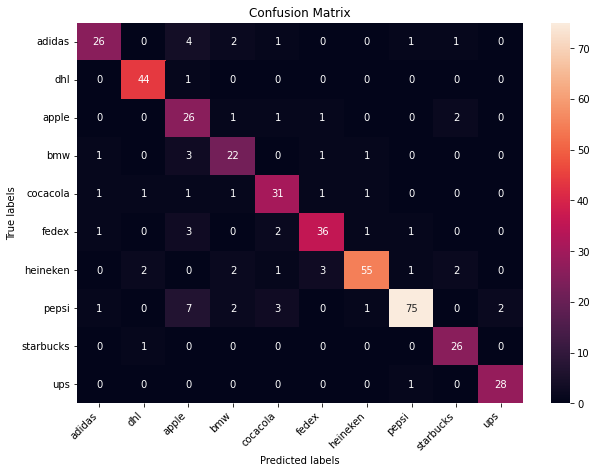

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, lsvc_preds)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0, ha='right')
plt.show()

In [ ]:
test_df['preds'] = lsvc_preds
test_df.loc[(test_df['preds']==2)&(test_df['class']=='pepsi'), 'merge_key'][:3]

# find the images in cn folder

11366    005873_06_bb_cn
11385    005851_01_bb_cn
11376    005873_16_bb_cn
Name: merge_key, dtype: object

## Model 2.3: KNN

In [ ]:
# Fit model
neigh = KNeighborsClassifier(n_neighbors=8, weights='distance') #<--- tuned n value on val set
neigh.fit(X_train_scaled_all, y_train)

# Generate preds
preds = neigh.predict(X_test_scaled_all)
y_proba = neigh.predict_proba(X_test_scaled_all)

# Get accuracy
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 46.88%



# Section 3: SIFT-only Modeling

In [ ]:
# Instantiate linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, multi_class = 'ovr', 
                 max_iter = 5000, C = 0.0001, class_weight=None)

# Fit the training histograms and predict with SVC on training data itself
lsvc.fit(X_train_scaled_sift, y_train)

# Generate preds
lsvc_preds = lsvc.predict(X_test_scaled_sift)

# Get accuracy
acc = accuracy_score(y_test, lsvc_preds)
print(f"Accuracy: {acc:.2%}\n")

Accuracy: 75.52%



In [ ]:
# Classification Report
print(classification_report(y_test, lsvc_preds, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.78      0.71      0.75        35
         dhl       0.83      0.84      0.84        45
       apple       0.36      0.61      0.45        31
         bmw       0.56      0.68      0.61        28
    cocacola       0.82      0.73      0.77        37
       fedex       0.83      0.80      0.81        44
    heineken       0.92      0.85      0.88        66
       pepsi       0.77      0.60      0.68        91
   starbucks       0.81      0.96      0.88        27
         ups       0.93      0.93      0.93        29

    accuracy                           0.76       433
   macro avg       0.76      0.77      0.76       433
weighted avg       0.78      0.76      0.76       433

